# <center><font color='#708090'>Project 04: Gathering, assessing, and cleaning data from WeRateDogs twitter account</center><br>
## Table of Contents
- [Introduction](#intro)
- [Gathering Data](#gathering)
    - [1. Loading the Twitter archive for WeRateDogs](#archive)
    - [2. Downloading and saving the image predictions dataset](#images)
    - [3. Getting tweets data](#counts)
- [Assessing Data](#assessing)
    - [1. twitter_archive Table](#tarchive)
    - [2. image_predictions Table](#ipredictions)
    - [3. twitter_api Table](#tapi)
    - [4. Assessment Findings](#findings)
- [Cleaning Data](#cleaning)
    - [1. Quality issues](#quality)
    - [2. Tidiness issues](#tidiness)
    - [3. Storing our work](#storing)
- [Analyses](#analyses)
- [Conclusions](#conclusions)
- [Limitations](#limitations)
- [Sources](#sources)

<a id='intro'></a>
# <font color='#6495ED'> Introduction

In this project we will be wrangling, analyzing, and visualizing the tweet archive of Twitter user **@dog_rates**, also known as **WeRateDogs**. **WeRateDogs** is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." **WeRateDogs** has over 4 million followers and has received international media coverage.

In [2]:
# loading the libraries
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as db
import tweepy
import requests
import json
import os
import re
import timeit
%matplotlib inline
sns.set_style("darkgrid")
pd.set_option('display.max_colwidth', 0)

<a id='gathering'></a>
# <font color='#6495ED'> Gathering Data

<a id='archive'></a>
### `1.` Loading the Twitter archive for WeRateDogs

In [4]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [7]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


<a id='images'></a>
### `2.` Downloading and saving the image predictions dataset

In [2]:
# creating a folder to save the downloaded data in it
folder_name = 'tweet_image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
# creating a response object
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

Now we can load the dataset

In [5]:
image_predictions = pd.read_csv('tweet_image_predictions/image-predictions.tsv', sep='\t')

In [13]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='counts'></a>
### `3.` Getting tweets data

- This will involve the following steps:
  - Creating and authenticating our api object using tweepy library.
  - Using the tweet IDs in the WeRateDogs Twitter archive to query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt` file.
  - Each tweet's JSON data will be written to its own line.
  - Reading this .txt file line by line into a pandas DataFrame with (at minimum) **tweet ID**, **retweet count**, and **like count**.
  - Loading our created DataFrame.

#### `3.1.` Creating the API object

In [7]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Creating API object
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# testing Authentication
try:
    api.verify_credentials()
    print('Authentication success')
except:
    print('Authentication failed')

Authentication success


#### `3.2.` Creating the JSON data file, which we will name `tweet_json.txt`

In [8]:
# creating an empty file
file_name = 'tweet_json.txt'
with open(file_name, 'w') as file:
    pass

In [9]:
# getting the tweets ids
tweets_id = twitter_archive['tweet_id'].tolist()
len(tweets_id)

2356

In [10]:
# querying the Twitter API for each tweet's JSON data

tweets_errors = {}
start = timeit.default_timer()

with open(file_name, 'w') as file:
    for _id in tweets_id:
        try:
            ranking = tweets_id.index(_id) + 1
            print(str(ranking) + '_' + str(_id))
            tweet = api.get_status(_id, tweet_mode='extended')._json
            json.dump(tweet, file)
            file.write('\n')
            
        except Exception as e:
            print(str(ranking) + '_' + str(_id) + ':' + str(e))
            tweets_errors[str(ranking) + '_' + str(_id)] = tweet

finish = timeit.default_timer()
print('Start at: {} - Finish at: {}'.format(start, finish))
print('Failed queries: \n', tweets_errors)

1_892420643555336193
2_892177421306343426
3_891815181378084864
4_891689557279858688
5_891327558926688256
6_891087950875897856
7_890971913173991426
8_890729181411237888
9_890609185150312448
10_890240255349198849
11_890006608113172480
12_889880896479866881
13_889665388333682689
14_889638837579907072
15_889531135344209921
16_889278841981685760
17_888917238123831296
18_888804989199671297
19_888554962724278272
20_888202515573088257
20_888202515573088257:[{'code': 144, 'message': 'No status found with that ID.'}]
21_888078434458587136
22_887705289381826560
23_887517139158093824
24_887473957103951883
25_887343217045368832
26_887101392804085760
27_886983233522544640
28_886736880519319552
29_886680336477933568
30_886366144734445568
31_886267009285017600
32_886258384151887873
33_886054160059072513
34_885984800019947520
35_885528943205470208
36_885518971528720385
37_885311592912609280
38_885167619883638784
39_884925521741709313
40_884876753390489601
41_884562892145688576
42_884441805382717440
43_

312_835297930240217089
313_835264098648616962
314_835246439529840640
315_835172783151792128
316_835152434251116546
317_834931633769889797
318_834786237630337024
319_834574053763584002
320_834477809192075265
321_834458053273591808
322_834209720923721728
323_834167344700198914
324_834089966724603904
325_834086379323871233
326_833863086058651648
327_833826103416520705
328_833732339549220864
329_833722901757046785
330_833479644947025920
331_833124694597443584
332_832998151111966721
333_832769181346996225
334_832757312314028032
335_832682457690300417
336_832645525019123713
337_832636094638288896
338_832397543355072512
339_832369877331693569
340_832273440279240704
341_832215909146226688
342_832215726631055365
343_832088576586297345
344_832040443403784192
345_832032802820481025
346_831939777352105988
347_831926988323639298
348_831911600680497154
349_831670449226514432
350_831650051525054464
351_831552930092285952
352_831322785565769729
353_831315979191906304
354_831309418084069378
355_8312626

655_791821351946420224
656_791784077045166082
657_791780927877898241
658_791774931465953280
659_791672322847637504
660_791406955684368384
661_791312159183634433
662_791026214425268224
663_790987426131050500
664_790946055508652032
665_790723298204217344
666_790698755171364864
667_790581949425475584
668_790337589677002753
669_790277117346975746
670_790227638568808452
671_789986466051088384
672_789960241177853952
673_789903600034189313
674_789628658055020548
675_789599242079838210
676_789530877013393408
677_789314372632018944
678_789280767834746880
679_789268448748703744
680_789137962068021249
681_788908386943430656
682_788765914992902144
683_788552643979468800
684_788412144018661376
685_788178268662984705
686_788150585577050112
687_788070120937619456
688_788039637453406209
689_787810552592695296
690_787717603741622272
691_787397959788929025
692_787322443945877504
693_787111942498508800
694_786963064373534720
695_786729988674449408
696_786709082849828864
697_786664955043049472
698_7865959

988_749036806121881602
989_748977405889503236
990_748932637671223296
991_748705597323898880
992_748699167502000129
993_748692773788876800
994_748575535303884801
995_748568946752774144
996_748346686624440324
997_748337862848962560
998_748324050481647620
999_748307329658011649
1000_748220828303695873
1001_747963614829678593
1002_747933425676525569
1003_747885874273214464
1004_747844099428986880
1005_747816857231626240
1006_747651430853525504
1007_747648653817413632
1008_747600769478692864
1009_747594051852075008
1010_747512671126323200
1011_747461612269887489
1012_747439450712596480
1013_747242308580548608
1014_747219827526344708
1015_747204161125646336
1016_747103485104099331
1017_746906459439529985
1018_746872823977771008
1019_746818907684614144
1020_746790600704425984
1021_746757706116112384
1022_746726898085036033
1023_746542875601690625
1024_746521445350707200
1025_746507379341139972
1026_746369468511756288
1027_746131877086527488
1028_746056683365994496
1029_745789745784041472
1030

1330_705898680587526145
1331_705786532653883392
1332_705591895322394625
1333_705475953783398401
1334_705442520700944385
1335_705428427625635840
1336_705239209544720384
1337_705223444686888960
1338_705102439679201280
1339_705066031337840642
1340_704871453724954624
1341_704859558691414016
1342_704847917308362754
1343_704819833553219584
1344_704761120771465216
1345_704499785726889984
1346_704491224099647488
1347_704480331685040129
1348_704364645503647744
1349_704347321748819968
1350_704134088924532736
1351_704113298707505153
1352_704054845121142784
1353_703774238772166656
1354_703769065844768768
1355_703631701117943808
1356_703611486317502464
1357_703425003149250560
1358_703407252292673536
1359_703382836347330562
1360_703356393781329922
1361_703268521220972544
1362_703079050210877440
1363_703041949650034688
1364_702932127499816960
1365_702899151802126337
1366_702684942141153280
1367_702671118226825216
1368_702598099714314240
1369_702539513671897089
1370_702332542343577600
1371_70232114048

1673_682389078323662849
1674_682303737705140231
1675_682259524040966145
1676_682242692827447297
1677_682088079302213632
1678_682059653698686977
1679_682047327939461121
1680_682032003584274432
1681_682003177596559360
1682_681981167097122816
1683_681891461017812993
1684_681694085539872773
1685_681679526984871937
1686_681654059175129088
1687_681610798867845120
1688_681579835668455424
1689_681523177663676416
1690_681340665377193984
1691_681339448655802368
1692_681320187870711809
1693_681302363064414209
1694_681297372102656000
1695_681281657291280384
1696_681261549936340994
1697_681242418453299201
1698_681231109724700672
1699_681193455364796417
1700_680970795137544192
1701_680959110691590145
1702_680940246314430465
1703_680934982542561280
1704_680913438424612864
1705_680889648562991104
1706_680836378243002368
1707_680805554198020098
1708_680801747103793152
1709_680798457301471234
1710_680609293079592961
1711_680583894916304897
1712_680497766108381184
1713_680494726643068929
1714_68047301164

2011_672248013293752320
2012_672245253877968896
2013_672239279297454080
2014_672231046314901505
2015_672222792075620352
2016_672205392827572224
2017_672169685991993344
2018_672160042234327040
2019_672139350159835138
2020_672125275208069120
2021_672095186491711488
2022_672082170312290304
2023_672068090318987265
2024_671896809300709376
2025_671891728106971137
2026_671882082306625538
2027_671879137494245376
2028_671874878652489728
2029_671866342182637568
2030_671855973984772097
2031_671789708968640512
2032_671768281401958400
2033_671763349865160704
2034_671744970634719232
2035_671743150407421952
2036_671735591348891648
2037_671729906628341761
2038_671561002136281088
2039_671550332464455680
2040_671547767500775424
2041_671544874165002241
2042_671542985629241344
2043_671538301157904385
2044_671536543010570240
2045_671533943490011136
2046_671528761649688577
2047_671520732782923777
2048_671518598289059840
2049_671511350426865664
2050_671504605491109889
2051_671497587707535361
2052_67148851333

2353_666044226329800704
2354_666033412701032449
2355_666029285002620928
2356_666020888022790149
Start at: 878.264732648 - Finish at: 2137.68953923
Failed queries: 
 {'20_888202515573088257': {'created_at': 'Sat Jul 22 00:23:06 +0000 2017', 'id': 888554962724278272, 'id_str': '888554962724278272', 'full_text': "This is Ralphus. He's powering up. Attempting maximum borkdrive. 13/10 inspirational af https://t.co/YnYAFCTTiK", 'truncated': False, 'display_text_range': [0, 87], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 888554915546542081, 'id_str': '888554915546542081', 'indices': [88, 111], 'media_url': 'http://pbs.twimg.com/media/DFTH_OiUMAE-k4M.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DFTH_OiUMAE-k4M.jpg', 'url': 'https://t.co/YnYAFCTTiK', 'display_url': 'pic.twitter.com/YnYAFCTTiK', 'expanded_url': 'https://twitter.com/dog_rates/status/888554962724278272/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 're

#### `3.3.`  Reading `tweet_json.txt` file line by line into a pandas DataFrame

In [22]:
df_list = []
decoding_errors = {}
with open('tweet_json.txt') as file:
    for line in file:
        try:
            content = json.loads(line)
            tweet_id = content['id']
            created_at = content['created_at']
            full_text = content['full_text']
            retweet_count = content['retweet_count']
            favorite_count = content['favorite_count']
            df_list.append({ 'tweet_id': tweet_id,
                             'created_at': created_at,
                             'full_text': full_text,
                             'retweet_count': retweet_count,
                             'favorite_count': favorite_count})
        except Exception as e:
            decoding_errors[str(tweet_id)] = e
print(decoding_errors)

{}


In [23]:
df_api = pd.DataFrame(df_list, columns=['tweet_id','created_at','full_text','retweet_count','favorite_count'])
df_api.to_csv('twitter_api_data.csv', index=False)

#### `3.4.` Loading the dataset

In [6]:
twitter_api = pd.read_csv('twitter_api_data.csv')

In [25]:
twitter_api.head()

,tweet_id,created_at,full_text,retweet_count,favorite_count
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,This is Phineas. He's a mystical boy. Only eve...,7487,35461
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,This is Tilly. She's just checking pup on you....,5557,30683
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,This is Archie. He is a rare Norwegian Pouncin...,3679,23080
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,This is Darla. She commenced a snooze mid meal...,7664,38739
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,This is Franklin. He would like you to stop ca...,8265,37011


<a id='assessing'></a>
# <font color='#6495ED'>Assessing Data

<a id='tarchive'></a>
### `1.` twitter_archive Table

In [10]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [13]:
for i,v in enumerate(twitter_archive):
    print(i,v)

0 tweet_id
1 in_reply_to_status_id
2 in_reply_to_user_id
3 timestamp
4 source
5 text
6 retweeted_status_id
7 retweeted_status_user_id
8 retweeted_status_timestamp
9 expanded_urls
10 rating_numerator
11 rating_denominator
12 name
13 doggo
14 floofer
15 pupper
16 puppo


### what's in a name
1. **`tweet_id`:** The integer representation of the unique identifier for this Tweet.
2. **`in_reply_to_status_id`:** Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID.
3. **`in_reply_to_user_id`:** Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
4. **`timestamp`:** This is probably equivalent to the created_at attribute, UTC time when this Tweet was created.
5. **`source`:** Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of *web*.
6. **`text`:** The actual UTF-8 text of the status update.
7. **`retweeted_status_id`:** Nullable. If the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID.
8. **`retweeted_status_user_id`:** Nullable. If the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID.
9. **`retweeted_status_timestamp`:** Time at which the retweet occurred.
10. **`expanded_urls`:** The tweet's url.
11. **`rating_numerator`:** The numerator for the dog's rating in the posted tweet.
12. **`rating_denominator`:** The denominator for the dog's rating in the posted tweet.
13. **`name`:** The dog's name.
14. **`doggo`:** A dog stage.
15. **`floofer`:** A dog stage.
16. **`pupper`:** A dog stage.
17. **`puppo`:** A dog stage.

<img src='dog_stages.png'>

In [5]:
twitter_archive.shape

(2356, 17)

In [6]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Something is wrong with the `rating_numerator` and `rating_denominator` columns. The **max** and **min** values and consequently the **standard deviation** are not what was expected.

In [23]:
# checking for denominators that are less than 10
twitter_archive.query('rating_denominator < 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None


From the result above, those don't look really like ratings, especially the 24/7 one. Let's view the original text and find out.

In [24]:
# viewing the text for rating denominators less than 10
twitter_archive.query('rating_denominator < 10')['text']

313     @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                                                       
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
2335    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv                                 
Name: text, dtype: object

In [33]:
# checking for denominators that are equal to zero
twitter_archive.query('rating_denominator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [29]:
# checking for extremely high numerators that are larger than the double of the denominator's mean value
twitter_archive.query('rating_numerator > 20')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None


In [30]:
# viewing the text for extreme numerator values
twitter_archive.query('rating_numerator > 20')['text']

188     @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research                                                                                   
189     @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10                                    
290     @markhoppus 182/10                                                                                                                                                       
313     @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                                                       
340     RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…                             
433     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   

So, some people just give arbitrary values for the numerator and denominator. But in many other cases, as we can see from the text above, the extreme value is due to people giving decimal values for the numerator and only the part after the decimal point is extracted.

In [8]:
# checking for duplicate rows in twitter_archive dataframe
twitter_archive.duplicated().sum()

0

In [81]:
# checking for duplicate value in columns that should have unique values all along
print('Number of duplicates in tweet_id:',twitter_archive.tweet_id.duplicated().sum(),'\n', 
      'Number of duplicates in timestamp:',twitter_archive.timestamp.duplicated().sum(),'\n',
      'Number of duplicates in text:',twitter_archive.text.duplicated().sum(),'\n',
      'Number of duplicates in expanded_urls:',twitter_archive.expanded_urls.duplicated().sum()
     )

Number of duplicates in tweet_id: 0 
 Number of duplicates in timestamp: 0 
 Number of duplicates in text: 0 
 Number of duplicates in expanded_urls: 137


In [15]:
# number of replies
twitter_archive.in_reply_to_status_id.notnull().sum()

78

In [16]:
# number of retweets
twitter_archive.retweeted_status_id.notnull().sum()

181

In [18]:
# viewing some samples from text column
twitter_archive.text.sample(50)

1095    Say hello to mad pupper. You know what you did. 13/10 would pet until no longer furustrated https://t.co/u1ulQ5heLX                                               
254     This is Charlie. He wants to know if you have a moment to talk about washing machine insurance policies. 11/10 would hear him out https://t.co/gAzPqT7uyk         
2331    Here we have a mixed Asiago from the Galápagos Islands. Only one ear working. Big fan of marijuana carpet. 8/10 https://t.co/tltQ5w9aUO                           
63      This is Romeo. He would like to do an entrance. Requesting your immediate assistance. 13/10 https://t.co/Qh5aEkRQm9                                               
605     RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…                      
1857    12/10 stay woke https://t.co/XDiQw4Akiw                                                                                                  

In [19]:
# number of each unique value in name column
twitter_archive.name.value_counts()

None        745
a           55 
Charlie     12 
Oliver      11 
Cooper      11 
Lucy        11 
Penny       10 
Tucker      10 
Lola        10 
Bo          9  
Winston     9  
the         8  
Sadie       8  
Toby        7  
Bailey      7  
Daisy       7  
an          7  
Buddy       7  
Rusty       6  
Scout       6  
Oscar       6  
Leo         6  
Bella       6  
Koda        6  
Jack        6  
Milo        6  
Jax         6  
Dave        6  
Stanley     6  
Sammy       5  
           ..  
Ozzie       1  
Kayla       1  
Pavlov      1  
Hall        1  
Sephie      1  
Rudy        1  
Stewie      1  
Lorelei     1  
Randall     1  
Vixen       1  
Clarq       1  
Griswold    1  
Vince       1  
Leonidas    1  
Al          1  
Ronnie      1  
Rinna       1  
Charl       1  
Tommy       1  
Teddy       1  
Ralf        1  
Tuco        1  
Tuck        1  
Ralphie     1  
Chase       1  
Dwight      1  
Banjo       1  
Butters     1  
Tino        1  
Cecil       1  
Name: name, Length: 957,

In [10]:
no_name = twitter_archive.query('name == "None"')['name'].count()
nonvalid_names = twitter_archive.name.str.islower().sum()
valid_names = twitter_archive.query('name != "None"')['name'].str.istitle().sum()

print(
    'Number of none names = {}\nNumber of non-valid names = {}\nNumber of valid names = {} '
    .format(no_name, nonvalid_names, valid_names)
)
print('Total names =',no_name + nonvalid_names + valid_names, '/',twitter_archive.shape[0])

Number of none names = 745
Number of non-valid names = 109
Number of valid names = 1496 
Total names = 2350 / 2356


In [5]:
# checking for dog names that are written in uppercase
mask = twitter_archive.name.str.isupper() == True
twitter_archive[mask]['name']

775      O
2041    JD
Name: name, dtype: object

O can be counted as both title and uppercase. meaning we still have other five names not accounted for. Let's now check if there are any numbers as names.

In [6]:
# checking if any dog has a number as a name
twitter_archive.name.str.isnumeric().sum()

0

In [16]:
# finding the remaining five names
remaining_names = twitter_archive.name.str.extract(r'(?P<names>[A-Z]{1,}[a-z]+[A-Z]+[a-z]*)')
remaining_names.names.value_counts()

CeCe      2
DayZ      1
DonDon    1
BeBe      1
Name: names, dtype: int64

In [17]:
# getting the text of tweets in which the remaining five names were mentioned
twitter_archive.query('name in ["CeCe","DayZ","DonDon","BeBe"]')['text']

652     Meet BeBe. She rocks the messy bun of your dreams. H*ckin flawless. 12/10 would watch her tutorial https://t.co/of0pFNBIl8                  
827     This is DonDon. He's way up but doesn't feel blessed. Rather uncomfortable actually. 12/10 I'll save you DonDon https://t.co/OCYLz3fjVE     
1412    Meet CeCe. She wanted to take a selfie before her first day as a lumberjack. 11/10 crushing traditional gender roles https://t.co/oW9XMYG3F4
1715    This is CeCe. She's patiently waiting for Santa. 10/10 https://t.co/ZJUypFFwvg                                                              
2221    Say hello to DayZ. She is definitely stuck on that stair. Just looking for someone to help her. 11/10 I would help https://t.co/be3zMW0Qj5  
Name: text, dtype: object

In [51]:
# viewing a sample of the data in source column
twitter_archive.source.sample(10)

1178    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1989    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1369    <a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                   
545     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1749    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
319     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2344    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1415    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1500    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1302    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object

In [57]:
# number of each unique value in source column
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [56]:
# viewing a sample of the data in expanded_urls column
twitter_archive.expanded_urls.sample(10)

1087    https://twitter.com/dog_rates/status/738156290900254721/photo/1                                                                                                                                                                                                                                             
2351    https://twitter.com/dog_rates/status/666049248165822465/photo/1                                                                                                                                                                                                                                             
650     https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1                                             
47      https://twitter.com/dog_rates/status/883117836046086144/photo/1,h

In [13]:
# viewing the rows containing duplicate expanded urls
twitter_archive[twitter_archive.expanded_urls.duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6",NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,NaN,NaN,NaN,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1",12,10,Sierra,None,None,pupper,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
126,868552278524837888,NaN,NaN,2017-05-27 19:39:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Cooper. His expression is the same wet or dry. Absolute 12/10 but Coop desperately requests your help\n\nhttps://t.co/ZMTE4Mr69f https://t.co/7RyeXTYLNi,NaN,NaN,NaN,"https://www.gofundme.com/3ti3nps,https://twitter.com/dog_rates/status/868552278524837888/photo/1,https://twitter.com/dog_rates/status/868552278524837888/photo/1",12,10,Cooper,None,None,None,None
135,866450705531457537,NaN,NaN,2017-05-22 00:28:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,10,Jamesy,None,None,pupper,None
136,866334964761202691,NaN,NaN,2017-05-21 16:48:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.co/W86h5dgR6c,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/866334964761202691/photo/1,https://twitter.com/dog_rates/status/866334964761202691/photo/1",12,10,Coco,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:

In [18]:
# getting the number of values that are not none in columns for dog stages
print('Number of doggo values = {}'.format(twitter_archive.doggo.value_counts()[1]),'\n'
       'Number of floofer values = {}'.format(twitter_archive.floofer.value_counts()[1]),'\n'
       'Number of pupper values = {}'.format(twitter_archive.pupper.value_counts()[1]),'\n'
       'Number of puppo values = {}'.format(twitter_archive.puppo.value_counts()[1])
     )

Number of doggo values = 97 
Number of floofer values = 10 
Number of pupper values = 257 
Number of puppo values = 30


In [22]:
# checking for presence of variations on some dog stages names
var_stages = twitter_archive.text.str.contains(r'doggo|puppo|blep\w+', case= False) == True 
twitter_archive[var_stages]['text']

9       This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A         
12      Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm                                    
14      This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq                        
29      This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox           
43      Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ  
61      Meet Jesse. He's a Fetty Woof. His tongue ejects without warning. A true bleptomaniac. 12/10 would snug well https://

Some dog stages are mentioned with some word play as in : bleptomaniac, BlepiPen, and puppoccino. also some stages mentioned with case variation such as: doggo and Doggo, needs to be considered.

<a id='ipredictions'></a>
### `2.` image_predictions Table

In [11]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
for i,v in enumerate(image_predictions):
    print(i,v)

0 tweet_id
1 jpg_url
2 img_num
3 p1
4 p1_conf
5 p1_dog
6 p2
7 p2_conf
8 p2_dog
9 p3
10 p3_conf
11 p3_dog


### what's in a name
1. **`tweet_id`:**  the last part of the tweet URL after "status/".
2. **`jpg_url`:** the image of the dog.
3. **`img_num`:** the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).
4. **`p1`:** the algorithm's first prediction for the image in the tweet.
5. **`p1_conf`:** how confident the algorithm is in its first prediction.
6. **`p1_dog`:** whether or not the first prediction is a breed of dog.
7. **`p2`:** the algorithm's second most likely prediction.
8. **`p2_conf`:** how confident the algorithm is in its second prediction.
9. **`p2_dog`:** whether or not the second prediction is a breed of dog.
10. **`p3`:** the algorithm's third most likely prediction.
11. **`p3_conf`:** how confident the algorithm is in its third prediction.
12. **`p3_dog`:** whether or not the third prediction is a breed of dog.

In [68]:
image_predictions.shape

(2075, 12)

In [46]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [66]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [67]:
image_predictions.duplicated().sum()

0

In [8]:
mask = image_predictions.jpg_url.duplicated() == True
jpg_duplicates = image_predictions[mask]
len(jpg_duplicates)

66

In [9]:
jpg_duplicates.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


In [12]:
# checking if above head rows from jpg_duplicates is a retweet or a reply in twitter_archive
twitter_archive.query('tweet_id in [752309394570878976,754874841593970688,757729163776290825,759159934323924993,759566828574212096]')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",10,10,None,None,None,None,None
895,759159934323924993,NaN,NaN,2016-07-29 22:53:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA,6.703191e+17,4.196984e+09,2015-11-27 19:11:49 +0000,"https://twitter.com/dog_rates/status/670319130621435904/photo/1,https://twitter.com/dog_rates/status/670319130621435904/photo/1",11,10,None,None,None,None,None
908,757729163776290825,NaN,NaN,2016-07-26 00:08:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Chompsky. He lives up to his name. 11/10 https://t.co/Xl37lQEWd0,6.790626e+17,4.196984e+09,2015-12-21 22:15:18 +0000,"https://twitter.com/dog_rates/status/679062614270468097/photo/1,https://twitter.com/dog_rates/status/679062614270468097/photo/1,https://twitter.com/dog_rates/status/679062614270468097/photo/1,https://twitter.com/dog_rates/status/679062614270468097/photo/1",11,10,Chompsky,None,None,None,None
926,754874841593970688,NaN,NaN,2016-07-18 03:06:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Rubio. He has too much skin. 11/10 https://t.co/NLOHmlENag,6.791584e+17,4.196984e+09,2015-12-22 04:35:49 +0000,"https://twitter.com/dog_rates/status/679158373988876288/photo/1,https://twitter.com/dog_rates/status/679158373988876288/photo/1",11,10,Rubio,None,None,None,None
949,752309394570878976,NaN,NaN,2016-07-11 01:11:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Everyone needs to watch this. 13/10 https://t.co/Bb3xnpsWBC,6.753544e+17,4.196984e+09,2015-12-11 16:40:19 +0000,"https://twitter.com/dog_rates/status/675354435921575936/video/1,https://twitter.com/dog_rates/status/675354435921575936/video/1",13,10,None,None,None,None,None


All are retweets as we can see.

In [10]:
# comparing a duplicated image in jpg_url with its duplicate
image_predictions.query('jpg_url =="https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1188,739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


In [5]:
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
malamute                     30 
cocker_spaniel               30 
French_bulldog               26 
Chesapeake_Bay_retriever     23 
miniature_pinscher           23 
seat_belt                    22 
Siberian_husky               20 
German_shepherd              20 
Staffordshire_bullterrier    20 
web_site                     19 
Cardigan                     19 
Maltese_dog                  18 
beagle                       18 
teddy                        18 
Shetland_sheepdog            18 
Eskimo_dog                   18 
Shih-Tzu                     17 
Rottweiler                   17 
Lakeland_terrier             17 
kuvasz                       16 
Italian_greyhound            16 
          

In [6]:
image_predictions.p2.value_counts()

Labrador_retriever                104
golden_retriever                  92 
Cardigan                          73 
Chihuahua                         44 
Pomeranian                        42 
Chesapeake_Bay_retriever          41 
French_bulldog                    41 
toy_poodle                        37 
cocker_spaniel                    34 
miniature_poodle                  33 
Siberian_husky                    33 
beagle                            28 
Eskimo_dog                        27 
collie                            27 
Pembroke                          27 
kuvasz                            26 
Italian_greyhound                 22 
American_Staffordshire_terrier    21 
Pekinese                          21 
miniature_pinscher                20 
malinois                          20 
chow                              20 
toy_terrier                       20 
Samoyed                           20 
Norwegian_elkhound                19 
Boston_bull                       19 
Staffordshir

In [7]:
image_predictions.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pekinese                          29
Pomeranian                        29
toy_poodle                        29
Great_Pyrenees                    27
Chesapeake_Bay_retriever          27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
b

<a id='tapi'></a>
### `3.` twitter_api Table

In [20]:
twitter_api

,tweet_id,created_at,retweet_count,favorite_count
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,7487,35461
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,5557,30683
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,3679,23080
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,7664,38739
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,8265,37011
5,891087950875897856,Sat Jul 29 00:08:17 +0000 2017,2767,18653
6,890971913173991426,Fri Jul 28 16:27:12 +0000 2017,1797,10840
7,890729181411237888,Fri Jul 28 00:22:40 +0000 2017,16762,59742
8,890609185150312448,Thu Jul 27 16:25:51 +0000 2017,3822,25675
9,890240255349198849,Wed Jul 26 15:59:51 +0000 2017,6506,29315


### what's in a name
1. **`tweet_id`:**  the last part of the tweet URL after "status/".
2. **`created_at`:** the time at which the tweet was created.
3. **`full_text`:** the text of the tweet.
4. **`retweet_count`:** the number of times a tweet has been retweeted by twitter users.
5. **`favorite_count`:** the number of times a Tweet has been liked by twitter users.

In [8]:
twitter_api.shape

(2331, 5)

In [9]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id          2331 non-null int64
created_at        2331 non-null object
full_text         2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3), object(2)
memory usage: 91.1+ KB


In [10]:
twitter_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2632.638782,7406.220077
std,6.823170e+16,4452.811149,11504.793061
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,534.500000,1286.500000
50%,7.182469e+17,1230.000000,3216.000000
75%,7.986692e+17,3055.500000,9063.000000
max,8.924206e+17,75652.000000,152825.000000


<a id='findings'></a>
### `4.` Assessment Findings

##### `4.1.` Quality issues:

a. **`twitter_archive` Table:**
  1. Retweets and replies and their associated columns are included in the dataset.
  2. Erroneous data types in `tweet_id` and `timestamp`.
  3. The `source` column contain the whole html element with its content, only the contents could be of use.
  4. many values in `expanded_urls` column seems to be duplicated inside the same cell and sometimes with urls for sites other than twitter.
  5. `rating_numerator` column has some wrong values due to some ratings containing decimal mark and only the digits after the mark are extracted.
  6. `rating_denominator` column has some wrong values such as: zero, and some others that were not meant as a rating, like 7 in 24/7 and 2 in 3 1\2 legged dog.
  7. `name` column contain many invalid names such as e.g: a, an, the, and such.
  8. `floofer` does not match the name mentioned in the dogtionary, which is floof. this suggests that many other occurances of this stage could be found. plus not all stages are represented here, snoot and blep are missing.
  9. Missing data in `name`, `doggo`, `floofer`, `pupper`, and `puppo` columns are represented by a "None" string.

b. **`image_predictions` Table:**
  1. Erroneous data types in `tweet_id`.
  2. Duplicate 66 images in `jpg_url` column probably due to replies and retweets.
  3. Naming conventions are not consistent in `p1`, `p2`, and `p3`. some values are in lowercase while other are first-letter uppercase.
  4. Column names are not much descriptive.

c. **`twitter_api` Table:**
  1. Erroneous data types in `tweet_id` and `created_at`

##### `4.2.` Tidiness issues:

a. **`twitter_archive` Table:**
  1. `doggo`, `floofer`, `pupper`, and `puppo` columns should all be represented by one colum for dog stage.
  2. columns like `name` and the four columns for the dog stage and the 2 for dog rating should not be in this table which contain tweets data. but instead in the table containing the dogs image predictions so together the form dogs data.

b. **`twitter_api` Table:**
  1. The columns in this table should be in `twitter_archive` table.

<a id='cleaning'></a>
# <font color='#6495ED'>Cleaning Data

Before performing any cleaning operation, we will make a copy of each dataframe. On this copies we are going to perform all the cleaning work, leaving the original dataframes intact.

In [7]:
# creating a copy of each dataframe before performing any cleaning process
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
twitter_api_clean = twitter_api.copy()

<a id='quality'></a>
### `1.` Quality issues

  a. **`twitter_archive` Table:**

*1.Retweets and replies and their associated columns are included in the dataset.*<br>
 **Define:**<br>
 Remove all rows that represent a retweet or a reply by removing rows that have non NaN value in `in_reply_to_status_id` and  `retweeted_status_id` columns. then drop these columns and other columns assciated with replies and retweets. which are : `in_reply_to_user_id`, `retweeted_status_user_id`,`retweeted_status_timestamp`.<br>

 **Code:**

In [8]:
# removing retweets
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notnull() == False]

# removing replies
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.notnull() == False]

Before dropping the columns, let's first make sure that we successfully removed retweets and replies.<br>
**Test:**

In [9]:
# checking for non NaN values in retweeted_status_id and in_reply_to_status_id
twitter_archive_clean.retweeted_status_id.notnull().sum(), twitter_archive_clean.in_reply_to_status_id.notnull().sum()

(0, 0)

In [10]:
# dropping columns associated with replies and retweets
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id',
                                                    'retweeted_status_timestamp'], axis=1)

In [11]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


*2.Erroneous data types in `tweet_id` and `timestamp`.*<br>
**Define:**<br>
Convert `tweet_id` column from int type to string using pandas astype(). convert `timestamp` column from object type to datetime using pandas astype().

**Code:**

In [12]:
# converting tweet_id to object type
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)

# convering timestamp to datetime
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.astype('datetime64')

**Test:**

In [13]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 213.0+ KB


*3.The `source` column contain the whole html element with its content, only the contents could be of use.*<br>
**Define:**<br>
Write a loop that extracts the content of each html element in `source` using BeautifulSoup. then using pandas replace each html element with the extracted text. then write another loop to replace the text with a much nicer shorter form.

**Code:**

In [14]:
# first loop to extract the text from the html element
for v in twitter_archive_clean.source:
    soup = BeautifulSoup(v, 'html.parser')
    twitter_archive_clean.source = twitter_archive_clean.source.str.replace(v,soup.get_text())

# second loop to replace the text with a short form   
for v in twitter_archive_clean.source:    
    t = {'Twitter for iPhone':'iPhone','Vine - Make a Scene':'Vine','Twitter Web Client':'Web Client','TweetDeck':'TweetDeck'}
    twitter_archive_clean.source = twitter_archive_clean.source.str.replace(v,t[v])

**Test:**

In [15]:
twitter_archive_clean.source.value_counts()

iPhone        1964
Vine          91  
Web Client    31  
TweetDeck     11  
Name: source, dtype: int64

*4.Many values in `expanded_urls` column seems to be duplicated inside the same cell and sometimes with urls for sites other than twitter.*<br>
**Define:**<br>
Extract the first twitter url from each value in `expanded_urls` column using pandas str.extract() method.

**Code:**

In [16]:
twitter_archive_clean.expanded_urls = twitter_archive_clean.expanded_urls.str.extract(r'(https://twitter.com/\w+/status/\d+)')

**Test:**

In [17]:
twitter_archive_clean.expanded_urls

0       https://twitter.com/dog_rates/status/892420643555336193
1       https://twitter.com/dog_rates/status/892177421306343426
2       https://twitter.com/dog_rates/status/891815181378084864
3       https://twitter.com/dog_rates/status/891689557279858688
4       https://twitter.com/dog_rates/status/891327558926688256
5       https://twitter.com/dog_rates/status/891087950875897856
6       https://twitter.com/dog_rates/status/890971913173991426
7       https://twitter.com/dog_rates/status/890729181411237888
8       https://twitter.com/dog_rates/status/890609185150312448
9       https://twitter.com/dog_rates/status/890240255349198849
10      https://twitter.com/dog_rates/status/890006608113172480
11      https://twitter.com/dog_rates/status/889880896479866881
12      https://twitter.com/dog_rates/status/889665388333682689
13      https://twitter.com/dog_rates/status/889638837579907072
14      https://twitter.com/dog_rates/status/889531135344209921
15      https://twitter.com/dog_rates/st

*5.`rating_numerator` column has some wrong values due to some ratings containing decimal mark and only the digits after the mark are extracted.*<br>
**Define:**<br>
Write a regex pattern to extract each dog rating as a numerator and denominator from the original tweet tex using pandas str.extract(). numbers with decimal mark should be considered while writing the regex pattern. after extracting the numerator and denominator convert them from string type to float using pandas astype().

**Code:**

In [18]:
# writing and compiling the regex pattern
pat_rating = re.compile(r'(?P<numerator>\d+[.]?\d*)/(?P<denominator>[1-9]\d+)')

# extracting the ratings with the regex
ratings_df = twitter_archive_clean.text.str.extract(pat_rating)

# assigning the result to our columns
twitter_archive_clean.rating_numerator, twitter_archive_clean.rating_denominator = ratings_df.numerator, ratings_df.denominator

# converting the columns type from string to float
twitter_archive_clean.rating_numerator, twitter_archive_clean.rating_denominator = twitter_archive_clean.rating_numerator.astype(float), twitter_archive_clean.rating_denominator.astype(float)

**Test:**

In [19]:
twitter_archive_clean[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2096.000000,2096.000000
mean,12.145887,10.454198
std,40.347097,6.643661
min,0.000000,10.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [20]:
twitter_archive_clean.rating_numerator.value_counts()

12.00      486
10.00      436
11.00      413
13.00      287
9.00       154
8.00       98 
7.00       52 
14.00      38 
5.00       33 
6.00       32 
3.00       19 
4.00       16 
2.00       9  
1.00       4  
13.50      1  
84.00      1  
0.00       1  
420.00     1  
50.00      1  
1776.00    1  
60.00      1  
44.00      1  
144.00     1  
88.00      1  
11.26      1  
11.27      1  
121.00     1  
9.75       1  
99.00      1  
204.00     1  
45.00      1  
165.00     1  
80.00      1  
Name: rating_numerator, dtype: int64

In [21]:
twitter_archive_clean.query('rating_numerator == 0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,2017-02-24 15:40:31,iPhone,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,https://twitter.com/dog_rates/status/835152434251116546,0.0,10.0,None,None,None,None,None


In [22]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2000 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null float64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 213.0+ KB


*6.`rating_denominator` column has some wrong values such as: zero, and some others that were not meant as a rating, like 7 in 24/7 and 2 in 3 1\2 legged dog.*<br>
**Define:**<br>
Solved along the previous issue. but furthermore, create a single column that represent dog ratings by dividing `rating_numerator` by `rating_denominator`. then drop these two columns.

**Code:**<br>
First we make sure that we eliminated the issues with the denominator.

In [23]:
twitter_archive_clean.query('rating_denominator in [0,2,7]')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [24]:
twitter_archive_clean['dog_rating'] = twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator']

twitter_archive_clean = twitter_archive_clean.drop(columns= ['rating_numerator','rating_denominator'])

**Test:**

In [25]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,dog_rating
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,Phineas,None,None,None,None,1.3


In [26]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id         2097 non-null object
timestamp        2097 non-null datetime64[ns]
source           2097 non-null object
text             2097 non-null object
expanded_urls    2000 non-null object
name             2097 non-null object
doggo            2097 non-null object
floofer          2097 non-null object
pupper           2097 non-null object
puppo            2097 non-null object
dog_rating       2096 non-null float64
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 196.6+ KB


In [27]:
twitter_archive_clean[twitter_archive_clean.dog_rating.notnull() == False]

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,dog_rating
516,810984652412424192,2016-12-19 23:06:23,iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,https://twitter.com/dog_rates/status/810984652412424192,Sam,None,None,None,None,NaN


In [28]:
twitter_archive_clean.dog_rating.describe()

count    2096.000000
mean     1.164233   
std      3.963847   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      177.600000 
Name: dog_rating, dtype: float64

*7.`name` column contain many invalid names such as e.g: a, an, the, and such.* <br>
**Define** <br>
Write a regex pattern to get dog names (if mentioned) from the tweet's text. Then use pandas str.extract() to implement the regex pattern and return the dog name if one is provided and a NaN if not. save the result to a new column named `dog_name` and drop the old `name` column.

**Code:**

In [29]:
# writing and compiling the regex pattern
pat_name = re.compile(r'(?:named\W+|name\W+is\W+|This\W+is\W+|this\W+is\W+|Meet\W+|meet\W+|hello\W+to\W+|Here\W+is\W+)([A-Z]{1,}\w+)')

# extract names and saving the result to dog_name
twitter_archive_clean['dog_name'] = twitter_archive_clean['text'].str.extract(pat_name)

# dropping the old name column
twitter_archive_clean = twitter_archive_clean.drop(columns=['name'])

**Test:**

In [30]:
twitter_archive_clean.dog_name.value_counts()

Lucy          11
Charlie       11
Cooper        10
Oliver        10
Tucker        9 
Penny         9 
Lola          8 
Sadie         8 
Winston       8 
Toby          7 
Daisy         7 
Bo            6 
Oscar         6 
Stanley       6 
Koda          6 
Jax           6 
Bella         6 
Bailey        6 
Buddy         5 
Rusty         5 
Dave          5 
Scout         5 
Chester       5 
Louis         5 
Milo          5 
Zoey          5 
Bentley       5 
Leo           5 
Derek         4 
Clark         4 
             .. 
Rubio         1 
Julius        1 
Stu           1 
Spencer       1 
Griswold      1 
Christoper    1 
Lacy          1 
Bauer         1 
Ralphus       1 
Sonny         1 
Rupert        1 
Winifred      1 
Nimbus        1 
Meatball      1 
Tyrone        1 
Boston        1 
Kellogg       1 
Kobe          1 
Florence      1 
Tripp         1 
Mack          1 
Beebop        1 
Willem        1 
Marq          1 
Jett          1 
Ed            1 
Teddy         1 
Oddie         

In [31]:
no_name = twitter_archive.query('name == "None"')['name'].count()
nonvalid_names = twitter_archive.name.str.islower().sum()
uppers = twitter_archive.query('name != "None"')['name'].str[0]
valid_names = uppers.str.isupper().sum()

print('Info for dog name entries in the original dataframe:')
print(
    'Number of none names = {}\nNumber of non-valid names = {}\nNumber of valid names = {} '
    .format(no_name, nonvalid_names, valid_names)
)
print('Total names =',no_name + nonvalid_names + valid_names, '/',twitter_archive.shape[0])
print('Ratio of valid names =',valid_names / twitter_archive.shape[0])

Info for dog name entries in the original dataframe:
Number of none names = 745
Number of non-valid names = 109
Number of valid names = 1502 
Total names = 2356 / 2356
Ratio of valid names = 0.637521222411


In [32]:
no_name_clean = twitter_archive_clean[twitter_archive_clean.dog_name.isna() == True].shape[0]
nonvalid_names_clean = twitter_archive_clean.dog_name.str.islower().sum()
uppers_clean = twitter_archive_clean.dog_name.str[0]
valid_names_clean = uppers_clean.str.isupper().sum()

print('Info for dog name entries in the cleaned dataframe:')
print(
    'Number of NaN = {}\nNumber of non-valid names = {}\nNumber of valid names = {} '
    .format(no_name_clean, nonvalid_names_clean, valid_names_clean)
)
print('Total names =',no_name_clean + nonvalid_names_clean + valid_names_clean, '/',twitter_archive_clean.shape[0])
print('Ratio of valid names =',valid_names_clean / twitter_archive_clean.shape[0])

Info for dog name entries in the cleaned dataframe:
Number of NaN = 676
Number of non-valid names = 0
Number of valid names = 1421 
Total names = 2097 / 2097
Ratio of valid names = 0.6776347162613257


In [33]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id         2097 non-null object
timestamp        2097 non-null datetime64[ns]
source           2097 non-null object
text             2097 non-null object
expanded_urls    2000 non-null object
doggo            2097 non-null object
floofer          2097 non-null object
pupper           2097 non-null object
puppo            2097 non-null object
dog_rating       2096 non-null float64
dog_name         1421 non-null object
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 196.6+ KB


*8.`floofer` does not match the name mentioned in the dogtionary, which is floof. this suggests that many other occurances of this stage could be found. plus not all stages are represented here, snoot and blep are missing.* <br>
**Define:**<br>
Write a regex pattern to extract dog stages from original tweet text, that will correctly represent stage names mentioned in the dictionary, and consider different case and word variations for the same stage. then use pandas str.extract() to implement the regex pattern and return the dog stage if one is provided and a NaN if not. save the result to a new column name `dog_stage` and drop the old columns for each stage. after that, use pandas to make all entries lowercase and replace each name variation for the same stage with official stage name.

**Code:**

In [34]:
# writing and compling the regex pattern
pat_stage = re.compile(r'(dogg\w*|puppe\w*|puppo\w*|blep\w*|snoot\w*|floof\w*)', re.I)

# extracting dog stages and saving the result to dog_stage
twitter_archive_clean['dog_stage'] = twitter_archive_clean.text.str.extract(pat_stage)

# converting dog_stage to lowercase
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.lower()

In [35]:
# droppin the four old columns for dog stage
twitter_archive_clean = twitter_archive_clean.drop(columns=['doggo','floofer','pupper','puppo'])

In [36]:
# replacing variations
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r'b\w+','blep')
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r'd\w+','doggo')
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r'f\w+','floof')
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r's\w+','snoot')
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r'puppo\w*','puppo')
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.str.replace(r'puppe\w+','pupper')

**Test:**

In [37]:
twitter_archive_clean.dog_stage.value_counts()

pupper    251
doggo     93 
floof     37 
puppo     30 
blep      3  
Name: dog_stage, dtype: int64

In [38]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id         2097 non-null object
timestamp        2097 non-null datetime64[ns]
source           2097 non-null object
text             2097 non-null object
expanded_urls    2000 non-null object
dog_rating       2096 non-null float64
dog_name         1421 non-null object
dog_stage        414 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 147.4+ KB


In [39]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,dog_rating,dog_name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,1.3,Phineas,NaN


*9.Missing data in `name`, `doggo`, `floofer`, `pupper`, and `puppo` columns are represented by a "None" string.* <br>
**Define:**<br>
Use pandas str.extract() which will return NaN if the name or stage was not provided.(solved in the previous two issues)

**Test:**

In [40]:
twitter_archive_clean[['dog_name','dog_stage']].isna().sum()

dog_name     676 
dog_stage    1683
dtype: int64

  b. **`image_predictions` Table:**

 *1.Erroneous data types in `tweet_id`.* <br>
 **Define:** <br>
 Convert `tweet_id` column from int type to string using pandas astype().

**Code:**

In [41]:
# converting tweet_id to object type
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)

**Test:**

In [42]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


 *2.Duplicate 66 images in `jpg_url` column probably due to replies and retweets.* <br>
 **Define:** <br>
 Remove rows with duplicate image in `jpg_url` column.

**Code:**

In [43]:
# removing rows with duplicate image
image_predictions_clean = image_predictions_clean[image_predictions_clean.jpg_url.duplicated() == False]

**Test:**

In [44]:
# checking for duplicates in jpg_url column
image_predictions_clean.jpg_url.duplicated().sum()

0

*3.Naming conventions are not consistent in `p1`, `p2`, and `p3`. some values are in lowercase while other are first-letter uppercase.* <br>
**Define:** <br>
Convert all values in `p1`, `p2`, and `p3` to lowercase.

**Code:**

In [45]:
# converting values in p1, p2, and p3 to lowercase
image_predictions_clean['p1'] = image_predictions_clean.p1.str.lower()
image_predictions_clean['p2'] = image_predictions_clean.p2.str.lower()
image_predictions_clean['p3'] = image_predictions_clean.p3.str.lower()

**Test:**

In [46]:
# checking if all entries has been converted to lowercase
print(image_predictions_clean.p1.str.islower().all())
print(image_predictions_clean.p2.str.islower().all())
print(image_predictions_clean.p3.str.islower().all())

True
True
True


*4.Column names are not much descriptive.* <br>
**Define:** <br>
Rename columns so that they are more descriptive and easy to understand.

**Code:**

In [47]:
image_predictions_clean.rename({'p1':'prediction_1',
                                'p1_conf':'confint_1',
                                'p1_dog':'isdog_1',
                                'p2':'prediction_2',
                                'p2_conf':'confint_2',
                                'p2_dog':'isdog_2',
                                'p3':'prediction_3',
                                'p3_conf':'confint_3',
                                'p3_dog':'isdog_3'}, axis=1, inplace=True)

**Test:**

In [48]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id        2009 non-null object
jpg_url         2009 non-null object
img_num         2009 non-null int64
prediction_1    2009 non-null object
confint_1       2009 non-null float64
isdog_1         2009 non-null bool
prediction_2    2009 non-null object
confint_2       2009 non-null float64
isdog_2         2009 non-null bool
prediction_3    2009 non-null object
confint_3       2009 non-null float64
isdog_3         2009 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


  c. **`twitter_api` Table:**

  *1.Erroneous data types in `tweet_id` and `created_at`* <br>
  **Define:** <br>
  Convert `tweet_id` column from int type to string using pandas astype(). convert `created_at` column from object type to datetime using pandas astype().

**Code:**

In [49]:
# converting tweet_id to object type
twitter_api_clean.tweet_id = twitter_api_clean.tweet_id.astype(str)

# convering created_at to datetime
twitter_api_clean.created_at = twitter_api_clean.created_at.astype('datetime64')

**Test:**

In [50]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id          2331 non-null object
created_at        2331 non-null datetime64[ns]
full_text         2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 91.1+ KB


<a id='tidiness'></a>
### `2.` Tidiness issues

a. **`twitter_archive` Table:**  

*1.`doggo`, `floofer`, `pupper`, and `puppo` columns should all be represented by one colum for dog stage.* <br>
**Define:** <br>
Create a single `dog_stage` column containing values for dog stages. (already solved)

**Test:**

In [51]:
twitter_archive_clean.head(3)

,tweet_id,timestamp,source,text,expanded_urls,dog_rating,dog_name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,1.3,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426,1.3,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864,1.2,Archie,NaN


*2.columns like `name` and the four columns for the dog stage and the 2 for dog rating should not be in this table which contain tweets data. but instead in the table containing the dogs image predictions so together the form dogs data.* <br>
**Define:** <br>
Create a new dataframe that contains data about dogs and the image predictions along with `tweets id`.

**Code:**

In [52]:
dog_df = twitter_archive_clean[['tweet_id','dog_name','dog_rating','dog_stage']]
dog_data = pd.merge(left=image_predictions_clean,
                    right=dog_df,
                    left_index=False,
                    right_index=False,
                    how='left')

**Test:**

In [53]:
dog_data.head(3)

,tweet_id,jpg_url,img_num,prediction_1,confint_1,isdog_1,prediction_2,confint_2,isdog_2,prediction_3,confint_3,isdog_3,dog_name,dog_rating,dog_stage
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,NaN,0.8,NaN
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,NaN,0.7,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,NaN,0.9,NaN


b. **`twitter_api` Table:** 

 *1.The columns in this table should be in `twitter_archive` table.* <br>
**Define:** <br>
Merge `twitter_api` table with `twitter_archive` table.

**Code:**

In [54]:
# merge twitter_archive_clean with twitter_api_clean and save the result to twitter_data_clean
twitter_data_clean = pd.merge(left=twitter_archive_clean,
                              right=twitter_api_clean,
                              left_index=False,
                              right_index=False,
                              how='left')

# drop create_at and full_text column as they are redundant and were just for comparing purposes
twitter_data_clean = twitter_data_clean.drop(columns=['created_at','full_text'])

**Test:**

In [55]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 10 columns):
tweet_id          2097 non-null object
timestamp         2097 non-null datetime64[ns]
source            2097 non-null object
text              2097 non-null object
expanded_urls     2000 non-null object
dog_rating        2096 non-null float64
dog_name          1421 non-null object
dog_stage         414 non-null object
retweet_count     2090 non-null float64
favorite_count    2090 non-null float64
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 180.2+ KB


In [56]:
twitter_data_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,dog_rating,dog_name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,1.3,Phineas,NaN,7487.0,35461.0


<a id='storing'></a>
### `3.` Storing our work

- Storing our cleaned dataset will go on as the following:
  1. We will save our cleaned data as it is in one master dataframe by merging `twitter_data_clean` with `image_predictions_clean` and store the result in a .csv file using pandas.
  2. We will collect related data each in its own table. Namely, dog data which is represented by the already created `dog_data` table, and tweet data for which we are going to create a new dataframe and call it `tweet_data`.
  3. We will store `tweet_data` and `dog_data` in one single database.

Let's start by creating an empty folder in which we will store our outputs:

In [82]:
# creating empty folder to store our cleaned data
folder_name = 'cleaned_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

#### `3.1.` Creating and saving the master dataframe

In [57]:
master_df = pd.merge(left=twitter_data_clean,
                     right=image_predictions_clean,
                     left_index=False,
                     right_index=False,
                     how='left')

In [58]:
master_df.head(1)

,tweet_id,timestamp,source,text,expanded_urls,dog_rating,dog_name,dog_stage,retweet_count,favorite_count,...,img_num,prediction_1,confint_1,isdog_1,prediction_2,confint_2,isdog_2,prediction_3,confint_3,isdog_3
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,1.3,Phineas,NaN,7487.0,35461.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


In [59]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 21 columns):
tweet_id          2097 non-null object
timestamp         2097 non-null datetime64[ns]
source            2097 non-null object
text              2097 non-null object
expanded_urls     2000 non-null object
dog_rating        2096 non-null float64
dog_name          1421 non-null object
dog_stage         414 non-null object
retweet_count     2090 non-null float64
favorite_count    2090 non-null float64
jpg_url           1971 non-null object
img_num           1971 non-null float64
prediction_1      1971 non-null object
confint_1         1971 non-null float64
isdog_1           1971 non-null object
prediction_2      1971 non-null object
confint_2         1971 non-null float64
isdog_2           1971 non-null object
prediction_3      1971 non-null object
confint_3         1971 non-null float64
isdog_3           1971 non-null object
dtypes: datetime64[ns](1), float64(7), object(13)
memory usa

In [60]:
master_df.to_csv('cleaned_data/twitter_archive_master.csv', index=False)

#### `3.2.` Creating `tweet_data` table

In [61]:
tweet_data = twitter_data_clean[['tweet_id','timestamp','source','text','retweet_count','favorite_count','expanded_urls']]
tweet_data.head(1)

,tweet_id,timestamp,source,text,retweet_count,favorite_count,expanded_urls
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,7487.0,35461.0,https://twitter.com/dog_rates/status/892420643555336193


Saving `tweet_data` and `dog_data` to csv files in case we wanted to check later.

In [62]:
# saving tweet_data to csv file
tweet_data.to_csv('cleaned_data/tweet_data.csv', index=False)

# saving dog_data to csv file
dog_data.to_csv('cleaned_data/dog_data.csv', index=False)

#### `3.3.` Storing `tweet_data` and `dog_data` in a database called `twitter_archive_master.db`

In [63]:
# Creating a SQLAlchemy engine and an empty master_db database
engine = db.create_engine('sqlite:///cleaned_data/twitter_archive_master.db')

In [64]:
# Storin tweet_data and dog_data in tables called tweets and dogs respectively, in master_db.db
tweet_data.to_sql('tweets', engine, index=False)
dog_data.to_sql('dogs', engine, index=False)

Let's now have a look at each table in `master_db` database

In [65]:
pd.read_sql('SELECT * FROM tweets LIMIT 3', engine)

,tweet_id,timestamp,source,text,retweet_count,favorite_count,expanded_urls
0,892420643555336193,2017-08-01 16:23:56.000000,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,7487.0,35461.0,https://twitter.com/dog_rates/status/892420643555336193
1,892177421306343426,2017-08-01 00:17:27.000000,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",5557.0,30683.0,https://twitter.com/dog_rates/status/892177421306343426
2,891815181378084864,2017-07-31 00:18:03.000000,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,3679.0,23080.0,https://twitter.com/dog_rates/status/891815181378084864


In [66]:
pd.read_sql('SELECT * FROM dogs LIMIT 3', engine)

,tweet_id,jpg_url,img_num,prediction_1,confint_1,isdog_1,prediction_2,confint_2,isdog_2,prediction_3,confint_3,isdog_3,dog_name,dog_rating,dog_stage
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,1,collie,0.156665,1,shetland_sheepdog,0.061428,1,None,0.8,None
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,1,miniature_pinscher,0.074192,1,rhodesian_ridgeback,0.072010,1,None,0.7,None
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,1,malinois,0.138584,1,bloodhound,0.116197,1,None,0.9,None


<a id='analyses'></a>
# <font color='#6495ED'> Analyses

- In this analysis we are going to investigate the following questions:
  1. Which are the ten most popular dog names?
  2. Which dog stage is most frequent in our dataset according to number of dogs it has?
  3. Which dog stage has the highest average rating?
  4. Are high rated dogs more likely to be favorited than low rated ones?
- This analysis is based on our wrangled version of the original tweet archive, with only the original tweets included.

Let's load our dataset first

In [3]:
df = pd.read_csv('cleaned_data/twitter_archive_master.csv')

In [4]:
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,dog_rating,dog_name,dog_stage,retweet_count,favorite_count,...,img_num,prediction_1,confint_1,isdog_1,prediction_2,confint_2,isdog_2,prediction_3,confint_3,isdog_3
0,892420643555336193,2017-08-01 16:23:56,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193,1.3,Phineas,NaN,7487.0,35461.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426,1.3,Tilly,NaN,5557.0,30683.0,...,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True


### `1.` Which are the ten most popular dog names?

In [5]:
dog_names = df.dog_name.value_counts()[0:10]
dog_names

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Tucker     9 
Penny      9 
Sadie      8 
Lola       8 
Winston    8 
Toby       7 
Name: dog_name, dtype: int64

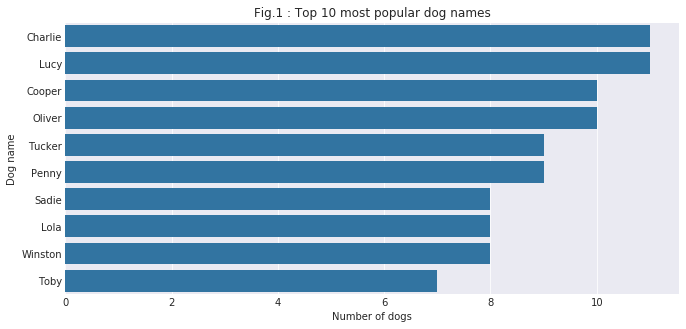

In [6]:
base_color = sns.color_palette()[0]
plt.figure(figsize=(11, 5))
sns.barplot(x=dog_names, y=dog_names.index, color=base_color)
plt.title('Fig.1 : Top 10 most popular dog names')
plt.xlabel('Number of dogs')
plt.ylabel('Dog name');

### `2.` Which dog stage is most frequent in our dataset according to number of dogs it has?

In [7]:
dog_stages = df.dog_stage.value_counts()

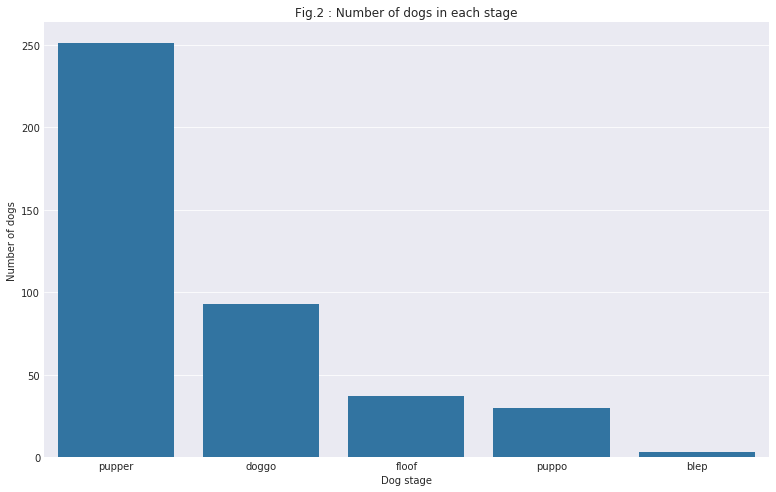

In [73]:
base_color = sns.color_palette()[0]
plt.figure(figsize=(13, 8))
sns.barplot(x=dog_stages.index, y=dog_stages, color=base_color)
plt.title('Fig.2 : Number of dogs in each stage')
plt.xlabel('Dog stage')
plt.ylabel('Number of dogs');

### `3.` Which dog stage has the highest average rating?

In [8]:
stage_rate = df[df.dog_stage.isna() == False][['dog_stage','dog_rating']]
stage_rate['dog_rating'] = stage_rate['dog_rating']*10
stage_rate.head(1)

,dog_stage,dog_rating
9,doggo,14.0


In [9]:
stage_rate.dog_rating.value_counts()

12.00     112
11.00     94 
10.00     70 
13.00     65 
9.00      20 
14.00     18 
8.00      17 
7.00      8  
6.00      3  
3.00      2  
5.00      2  
11.26     1  
11.27     1  
420.00    1  
Name: dog_rating, dtype: int64

In [10]:
# removing the most extreme rating
stage_rate = stage_rate[stage_rate.dog_rating != 420]

In [11]:
stage_rate.groupby('dog_stage').describe()

dog_rating                                                   
               count       mean       std   min   25%   50%   75%   max
dog_stage                                                              
blep       3.0        12.333333  0.577350  12.0  12.0  12.0  12.5  13.0
doggo      92.0       11.717391  1.646349  5.0   11.0  12.0  13.0  14.0
floof      37.0       11.675676  0.747368  10.0  11.0  12.0  12.0  13.0
pupper     251.0      10.723227  1.792108  3.0   10.0  11.0  12.0  14.0
puppo      30.0       12.166667  1.176885  9.0   12.0  12.5  13.0  14.0

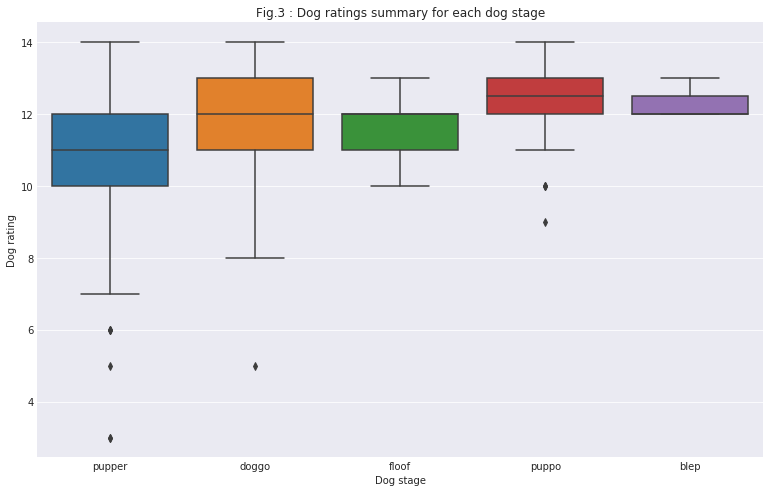

In [12]:
# creating categorical type from dog_stage
stages = stage_rate.dog_stage.value_counts().index
stagescat = pd.api.types.CategoricalDtype(ordered=True, categories= stages)

# converting dog_stage to stagecat type instead of object type
stage_rate['dog_stage'] = stage_rate.dog_stage.astype(stagescat)

# creating the boxplot
plt.figure(figsize=(13, 8))
sns.boxplot(data=stage_rate, x='dog_stage', y='dog_rating')
plt.title('Fig.3 : Dog ratings summary for each dog stage')
plt.xlabel('Dog stage')
plt.ylabel('Dog rating');

### `4.` Are high rated dogs more likely to be favorited than low rated ones?

In [79]:
fav_rating = df[['dog_rating','favorite_count']]
fav_rating.head(1)

,dog_rating,favorite_count
0,1.3,35461.0


In [80]:
fav_rating.groupby('dog_rating').describe()

favorite_count                                                 \
                    count          mean           std      min       25%   
dog_rating                                                                 
0.000000    1.0            22001.000000 NaN            22001.0  22001.00   
0.100000    4.0            6357.750000   5184.045549   782.0    4242.50    
0.200000    10.0           2187.800000   1976.674806   371.0    581.75     
0.300000    19.0           2114.052632   1579.847161   451.0    950.00     
0.400000    15.0           2432.533333   1415.584375   505.0    1042.00    
0.500000    33.0           2334.909091   2507.928844   96.0     761.00     
0.600000    32.0           2410.093750   2922.403401   100.0    903.75     
0.636364    1.0            35774.000000 NaN            35774.0  35774.00   
0.700000    51.0           2681.862745   3433.016021   98.0     662.50     
0.800000    98.0           2166.265306   2197.542111   104.0    721.75     
0.818182    1.0            34202.000000 NaN            34202.0  34202.00   
0.900000    154.0          2152.590909   2015.198567   94.0     778.00     
0.975000    1.0            18172.000000 NaN            18172.0  18172.00   
1.000000    437.0          3684.972540   5672.346254   94.0     1068.00    
1.100000    418.0          6214.885167   6157.673677   69.0     2335.25    
1.126000    1.0            1674.000000  NaN            1674.0   1674.00    
1.127000    1.0            6503.000000  NaN            6503.0   6503.00    
1.200000    488.0          10023.952869  10038.391784  175.0    3100.25    
1.300000    283.0          20577.441696  20373.707373  539.0    8418.50    
1.350000    1.0            42146.000000 NaN            42146.0  42146.00   
1.400000    38.0           26752.315789  17208.989290  3317.0   13786.25   
42.000000   1.0            23230.000000 NaN            23230.0  23230.00   
177.600000  1.0            5020.000000  NaN            5020.0   5020.00    

                                         
                50%       75%       max  
dog_rating                               
0.000000    22001.0  22001.00  22001.0   
0.100000    5666.0   7781.25   13317.0   
0.200000    1322.5   3680.00   5291.0    
0.300000    1784.0   2936.00   6300.0    
0.400000    2931.0   3306.50   4747.0    
0.500000    1713.0   2326.00   10379.0   
0.600000    1424.0   2582.75   15804.0   
0.636364    35774.0  35774.00  35774.0   
0.700000    1491.0   3191.50   17911.0   
0.800000    1567.0   2994.50   12234.0   
0.818182    34202.0  34202.00  34202.0   
0.900000    1905.0   2894.50   16362.0   
0.975000    18172.0  18172.00  18172.0   
1.000000    2356.0   4170.00   73363.0   
1.100000    3737.5   8458.25   42477.0   
1.126000    1674.0   1674.00   1674.0    
1.127000    6503.0   6503.00   6503.0    
1.200000    7379.5   13669.00  84757.0   
1.300000    16090.0  25680.50  152825.0  
1.350000    42146.0  42146.00  42146.0   
1.400000    24159.0  33469.50  86473.0   
42.000000   23230.0  23230.00  23230.0   
177.600000  5020.0   5020.00   5020.0

In [81]:
# removing the two extreme ratings
fav_rating = fav_rating[fav_rating.dog_rating < 2]

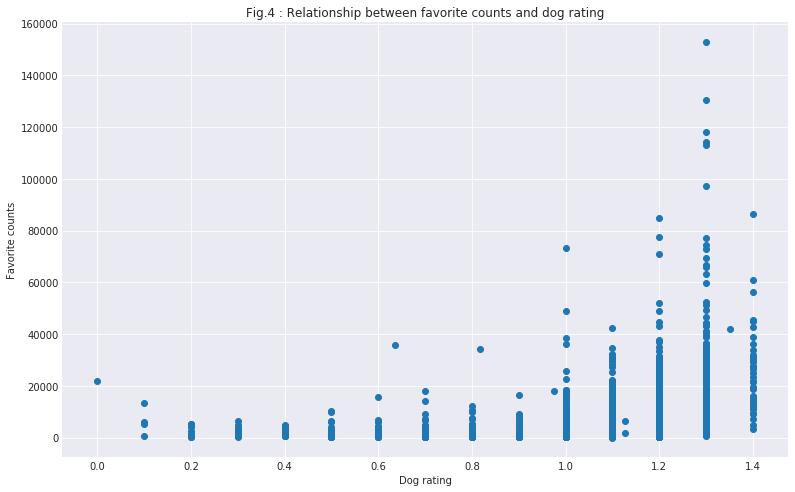

In [82]:
# creating the scatterplot
plt.figure(figsize=(13, 8))
plt.scatter(x=fav_rating['dog_rating'],y=fav_rating['favorite_count'])
plt.title('Fig.4 : Relationship between favorite counts and dog rating')
plt.xlabel('Dog rating')
plt.ylabel('Favorite counts');

<a id='conclusions'></a>
# <font color='#6495ED'> Conclusions

`1.` *Which are the ten most popular dog names?*
  - As we can see in Fig.1, Lucy and Charlie are the two most popular names for female and male dogs, respectively. Followed by Cooper, Oliver, and Tucker. And at number 10 we have Toby.

`2.` *Which dog stage is most frequent in our dataset according to number of dogs it has?*
  - From Fig.2, the dog stage with the most dogs in pupper followed by doggo, floof, puppo, and at the end comes blep with only 3 dogs.

`3.` *Which dog stage has the highest average rating?*
  - Keeping in mind the varying number of dogs in each stage, and that the number of dogs in blep stage are so few that they cannot be representative(only 3 dogs), the stage with the highest average rating is the puppo stage which has an average rating of 12.166667 for 30 dogs, followed by the doggo stage with an average rating of 11.717391 for 92 dogs.

`4.` *Are high rated dogs more likely to be favorited than low rated ones?*
  - From Fig.4 we can see a positive relationship between dog ratings and favorite counts .The higher the dog rating the more likely it is to get favorited.

<a id='limitations'></a>
# <font color='#6495ED'> Limitations

- The following notes should be considered when reviewing the above analyses:
  - The name entries provided in the dataset are not complete as not not all users provided their dog name in the original tweet post. In the above dataset we have 1421 dog name out of 2097.
  - The case of the dog stage is even much worse as much fewer users gave a stage to their dog in the original tweet post. In the above dataset we have only 414 provided dog stage out of 2097, even less than a quarter.

<a id='sources'></a>
# <font color='#6495ED'> Sources

### `1.` Gathering Data
  - [Tweepy account methods documentation](http://docs.tweepy.org/en/latest/api.html#account-methods)
  - [Tweepy status methods documentation](http://docs.tweepy.org/en/latest/api.html#status-methods)
  - [How to make a twitter bot in python with tweepy](https://realpython.com/twitter-bot-python-tweepy)
  - [Converting tweepy status object to json](https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json)
  - [Saving tweets to json file in python](https://stackoverflow.com/questions/48157921/saving-tweets-to-json-file-in-python-3-6)
  - [Parsing data from json into a pandas dataframe](https://stackoverflow.com/questions/59094921/parsing-data-from-json-tweepy-into-a-pandas-dataframe)
  - [Reading json file as pandas dataframe](https://stackoverflow.com/questions/48614158/read-json-file-as-pandas-dataframe)
  - [Python json library basic usage](https://docs.python.org/3/library/json.html#basic-usage)

### `2.` Assessing Data
  - [Pandas options and settings guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html)
  - [Pandas documentation for set_option() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html)

### `3.` Cleaning and storing Data
  - [Extract words surrounding a word and insert results in a dataframe column](https://stackoverflow.com/questions/45470373/extract-words-surrounding-a-word-and-inserting-results-in-a-dataframe-column)
  - [Pandas documentation for str.extract() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html)
  - [Extract HTML element content with BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#contents-and-children)
  - [Pandas guide to working with text](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html)
  - [Converting string to datetime format in pandas](https://stackoverflow.com/questions/32204631/how-to-convert-string-to-datetime-format-in-pandas-python)
  - [Pandas documentation for merge() function.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)
  - [Difference between join and merge in pandas](https://stackoverflow.com/questions/22676081/what-is-the-difference-between-join-and-merge-in-pandas)
  - [creating a database engine with sqlalchemy](https://docs.sqlalchemy.org/en/14/core/engines.html)
  - [Pandas documentation for to_sql() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html)

### `4.` Analyzing Data
  - [Pandas guide for categorical data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)
  - [Pandas documentation for CategoricalDtype](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.CategoricalDtype.html)
  - [Seaborn boxplot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html)
  - [Choosing a color palette in seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html)